In [7]:
import random
import torch
import torch.nn as nn 
import torch.backends.cudnn as cudnn 
import torch.optim as optim
from torchvision.utils import make_grid
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F
import math
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt

In [2]:
class DeepInversionFeatureHook():
    def __init__(self,module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,inputs,output):
        nch = inputs[0].shape[1]
        mean = inputs[0].mean([0,2,3])
        var = inputs[0].permute(1,0,2,3).contiguous().view(nch,-1).var(1,unbiased=False)
        r_feature = torch.norm(module.running_var.data.type(var.type()) - var, 2) \
                    + torch.norm(module.running_mean.data.type(var.type()) - mean, 2) \
        
        self.r_feature = r_feature
    def close():
        self.hook.remove()

In [38]:
emb_target = torch.load('save/emb_1.pt').cuda()
emb_target = emb_target.expand(16,-1).cuda()

In [4]:
loss_r_feature_layers = []
net = get_model('r100',fp16=False).eval().cuda()
net.load_state_dict(torch.load('/private/data/backbone.pth'))
for module in net.modules():
    if isinstance(module,nn.BatchNorm2d):
        loss_r_feature_layers.append(DeepInversionFeatureHook(module))

In [5]:
image_dim = 112
lr = 0.5
epochs = 1000

In [1]:
inputs = torch.randn((16,3,112,112), requires_grad = True,device='cuda')
loss_r_feature_layers = []
net = get_model('r100',fp16=False).eval().cuda()
net.load_state_dict(torch.load('/private/data/backbone.pth'))
for module in net.modules():
    if isinstance(module,nn.BatchNorm2d):
        loss_r_feature_layers.append(DeepInversionFeatureHook(module))
with torch.no_grad():
    inputs[:] = (inputs + torch.flip(inputs,[3]))/2
    pass
optimizer = optim.Adam([inputs],lr=lr)
# optimizer = optim.SGD([inputs],lr=lr,momentum=0.9)
lambda1 = lambda epoch: 0.5 * (math.cos(epoch/epochs*math.pi)+1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
losses = []
stat = [[],[],[],[]]
lim_0,lim_1=1,1
for epoch in range(epochs):
    with torch.no_grad():
        if epoch % 5 ==0:
            off1 = random.randint(-lim_0, lim_0)
            off2 = random.randint(-lim_1, lim_1)
            inputs[:] = torch.roll(inputs, shifts=(off1,off2), dims=(2,3))
    optimizer.zero_grad()
    net.zero_grad()
    net.eval()
    
    emb_out = net(inputs)
    
    cos_loss = torch.cosine_similarity(emb_target,emb_out)
    print(cos_loss.shape)
    norm_loss = ((torch.norm(emb_target,dim=1)-torch.norm(emb_out,dim=1))**2)
    print(norm_loss.shape)
    diff1 = inputs[:,:,:,:-1] - inputs[:,:,:,1:]
    diff2 = inputs[:,:,:-1,:] - inputs[:,:,1:,:]
    diff3 = inputs[:,:,1:,:-1] - inputs[:,:,:-1,1:]
    diff4 = inputs[:,:,:-1,:-1] - inputs[:,:,1:,1:]
#     print(torch.norm(diff1,dim=[1,2,3]).shape)
#     var_loss = torch.norm(diff1,dim=[1]) + torch.norm(diff2,dim=[1]) + torch.norm(diff3,dim=[1,2,3]) + torch.norm(diff4,dim=[1,2,3])
#     var_loss = var_loss
    
#     print(var_loss.shape, diff2.shape)
#     batch_loss = sum([mod.r_feature for mod in loss_r_feature_layers])
    batch_loss =[mod.r_feature for mod in loss_r_feature_layers]
    print(batch_loss[0].shape)
    break
    loss = -10*cos_loss + 2*norm_loss + 0.01*var_loss + 100*batch_loss

    loss.backward()
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        stat[0].append(cos_loss.sum().item())
        stat[1].append(norm_loss.sum().item())
        stat[2].append(var_loss.sum().item())
        stat[3].append(batch_loss.sum().item())
        inputs[:] = (inputs + torch.flip(inputs,[3]))/2
        inputs.clamp(-1,1)
    if epoch %25 ==24:
#         with torch.no_grad():
#         inputs = torch.roll(inputs, shifts=(off1,off2), dims=(2,3))
        clear_output(wait=True)
        #display.set_matplotlib_formats('svg')
        plt.figure(dpi=70)
        plt.subplot(221),plt.plot(stat[0]),plt.subplot(222),plt.plot(stat[1]),plt.subplot(223),plt.plot(stat[2]),plt.subplot(224),plt.plot(stat[3]),plt.show()
        save_image(inputs.detach().cpu(),'o.png',normalize=True,nrow=8)
        display(showIm(filename='o.png'))
        plt.show()

NameError: name 'torch' is not defined

In [49]:
inputs.shape

torch.Size([16, 3, 112, 112])

In [ ]:
a = torch.ones(10,requires_grad=True)
b = torch.randn(10)
(a*b).sum().backward()
print(a.grad)

In [ ]:
inputs[:,:,:,:-1].shape

In [ ]:
norm_loss

In [ ]:
import numpy as np
a = np.arange(1000).reshape(4,-1)

NameError: name 'a' is not defined

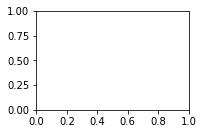

In [13]:
plt.subplot(221),plt.plot(a[0]),plt.plot(a[3])
plt.subplot(222),plt.plot(a[0]),plt.plot(a[3])
plt.subplot(223),plt.plot(a[0]),plt.plot(a[3])
plt.subplot(224),plt.plot(a[0]),plt.plot(a[3])

In [27]:
make_grid(inputs.cpu().detach(),nrow=8,normalize=True).permute(1,2,0).min()

tensor(0.)

In [21]:
from torchvision.utils import save_image
from IPython.display import Image as showIm
from IPython.display import display

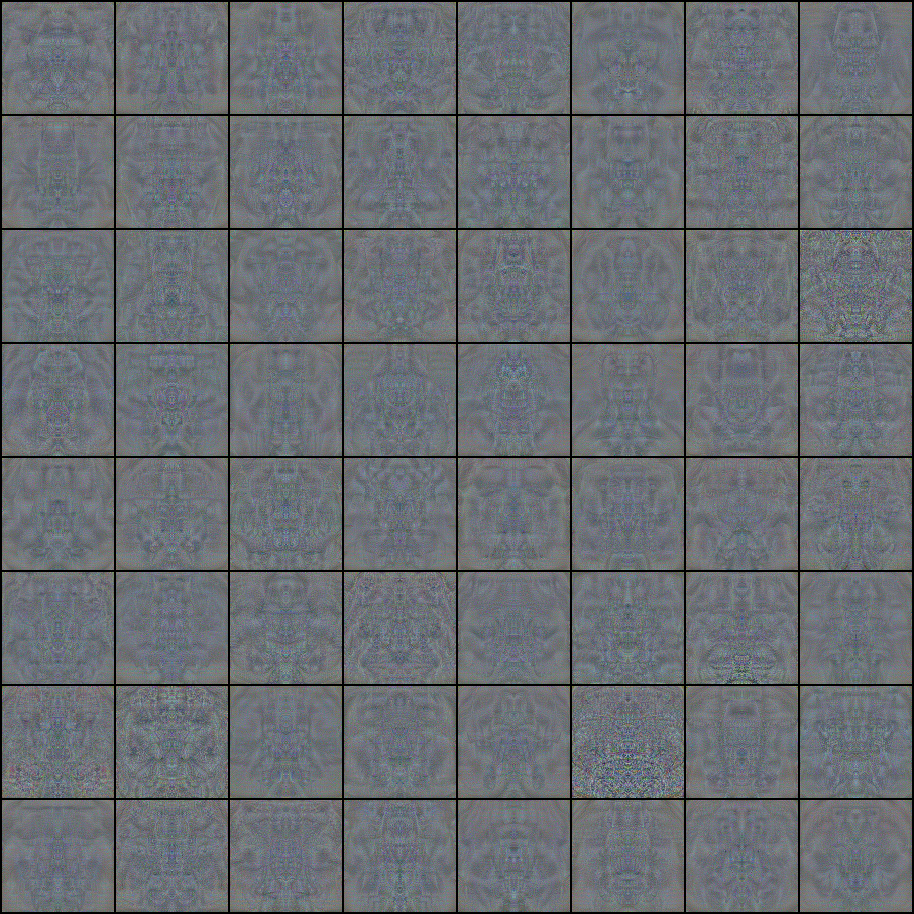

CPU times: user 607 ms, sys: 0 ns, total: 607 ms
Wall time: 196 ms


In [23]:
%%time
save_image(inputs.detach().cpu(),'o.png',normalize=True,nrow=8)
display(showIm(filename='o.png'))

In [34]:
emb_target.shape, emb_out.shape

(torch.Size([1, 512]), torch.Size([16, 512]))

In [35]:
emb_out

tensor([[ 0.6526,  0.0184,  0.8597,  ..., -1.1479, -0.9876,  1.0022],
        [ 0.9239,  0.3144,  0.9202,  ..., -0.1640, -0.4162, -0.6089],
        [-0.1605, -0.2813, -1.1032,  ...,  0.8960, -0.5842,  1.5816],
        ...,
        [ 0.2075,  1.1403, -0.0717,  ..., -1.2783, -0.5913,  1.6193],
        [ 1.3386, -0.9510, -0.3405,  ..., -0.4629,  1.0833, -2.4782],
        [-0.9149, -1.0014,  0.4351,  ..., -0.7654, -0.6585,  1.8821]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward>)

In [37]:
emb_target = emb_target.expand(16,-1).cuda()
emb_target

tensor([[ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556],
        [ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556],
        [ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556],
        ...,
        [ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556],
        [ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556],
        [ 0.1248,  0.8315, -0.7730,  ..., -1.3405,  1.2792,  1.5556]],
       device='cuda:0')

In [54]:
x= torch.arange(20).view(4,-1)

In [55]:
x

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])

In [58]:
torch.roll(x,[1,1],[0,1])

tensor([[19, 15, 16, 17, 18],
        [ 4,  0,  1,  2,  3],
        [ 9,  5,  6,  7,  8],
        [14, 10, 11, 12, 13]])

In [69]:
a = torch.arange(5*6*7).view(5,6,-1)

In [70]:
a.shape

torch.Size([5, 6, 7])

In [74]:
a.norm(dim=[1,2])

tensor([ 154,  412,  681,  952, 1224])